In [18]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix,recall_score,precision_recall_curve,auc,roc_curve,roc_auc_score,classification_report
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import f1_score

In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.over_sampling import SMOTE
from imblearn.metrics import classification_report_imbalanced
import xgboost as xgb
from xgboost import XGBClassifier
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import time

In [29]:
def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns

In [21]:
def prepareTrainData(csv_file):
    df=pd.read_csv(csv_file,sep=';',lineterminator='\n')
    df['type']='Train'
    missing_in_train=missing_values_table(df)
    missing_in_train.reset_index(inplace=True)
    drop_cols=np.unique(missing_in_train[missing_in_train['% of Total Values']>=50]['index'])
    df_new=df.drop(drop_cols,axis=1)
    return df_new,drop_cols

In [22]:
def prepareData(train_csv,test_csv):
    ## preprocess
    df_train,drop_cols=prepareTrainData(train_csv)
    df=pd.read_csv(test_csv,sep=';',lineterminator='\n')
    df['type']='Test'
    df_new=df.drop(drop_cols,axis=1)
    df_test=df_new.copy()
    df_test.rename(columns={'GUID':'ID'},inplace=True)
    df_total=pd.concat([df_train,df_test],axis=0)
    df_total=df_total[~df_total['Country'].isnull()]
    df1=df_total[~df_total['Description'].isnull()]
    df1['Price'] = df1['Price'].astype(float)
    df1['Price'].describe()
    df_temp=df1.Property_Type.value_counts().reset_index()
    drop_data_property=np.unique(df_temp[df_temp['Property_Type']<10]['index'])
    df1a=df1[~df1['Property_Type'].isin(drop_data_property)]
    print(df1a.shape)
    df1a.Amenities = df1a.Amenities.str.replace("[{}]", "").str.replace('"', "")
    df11=df1a[~df1a['Amenities'].isnull()]
    df11['Cleaning_Fee'] = df11['Cleaning_Fee'].fillna(value=0)
    df11['Cleaning_Fee'] = df11['Cleaning_Fee'].replace( '[\$,)]','', regex=True ).astype(float)
    df11.Features = df11.Features.str.replace("[{}]", "").str.replace('"', "")
    feat=set()
    for i,row in df11.iterrows():
        if pd.notna(row['Features']):
            l=row['Features'].split(',')
            for j in l:
                feat.add(j)
    df12=df11.copy()
    df12['Host Identity Verified']=df12.apply(lambda x :1 if pd.notnull(x['Features']) and 'Host Identity Verified' in x['Features'] else 0, axis=1)
    df12['Host Has Profile Pic']=df12.apply(lambda x :1 if pd.notnull(x['Features']) and 'Host Has Profile Pic' in x['Features'] else 0, axis=1)
    df12['Host Is Superhost']=df12.apply(lambda x :1 if pd.notnull(x['Features']) and 'Host Is Superhost' in x['Features'] else 0, axis=1)
    df12['Instant Bookable']=df12.apply(lambda x :1 if pd.notnull(x['Features']) and 'Instant Bookable' in x['Features'] else 0, axis=1)
    df12['Is Location Exact']=df12.apply(lambda x :1 if pd.notnull(x['Features']) and 'Is Location Exact' in x['Features'] else 0, axis=1)
    df12['Require Guest Phone Verification']=df12.apply(lambda x :1 if pd.notnull(x['Features']) and 'Require Guest Phone Verification' in x['Features'] else 0, axis=1)
    df12['Requires License']=df12.apply(lambda x :1 if pd.notnull(x['Features']) and 'Requires License' in x['Features'] else 0, axis=1)
    df13 = df12[['Host Has Profile Pic', 'Host Identity Verified', 'Host Is Superhost','Instant Bookable', 
                             'Is Location Exact', 'Require Guest Phone Verification', 'Requires License', 
                         'Guests_Included','Calculated_host_listings_count','Accommodates',
                               'Cleaning_Fee', 'Extra_People',
                             'Host_Listings_Count', 'Host_Total_Listings_Count', 'Minimum_Nights','Maximum_Nights','Beds',
                         'Bathrooms', 'Bedrooms', 'Number_of_Reviews', 'Price',
                'Availability_30',
           'Availability_60', 'Availability_90', 'Availability_365','ID']]

    for col in df13.columns[df13.isnull().any()]:
        df13[col] = df13[col].fillna(df13[col].median())

    for cat_feature in ['Property_Type', 'Cancellation_Policy', 'Bed_Type','Room_Type']:
        df13 = pd.concat([df13, pd.get_dummies(df12[cat_feature])], axis=1)

    df13 = pd.concat([df13, df12['Listing_Type']], axis=1)
    
    df_amenities=create_bow(df11,'Amenities')

    df14 = pd.concat([df13, df_amenities], axis=1, join='inner')

    df14a=pd.concat([df14, df12['type']], axis=1, join='inner')
    print(df14a.shape)

    df14a['Listing_Type']=df14a.apply(lambda x : 1 if x['Listing_Type']=='Good' else 0, axis=1) 
   
    return df14a

In [23]:
def create_bow(df,col):
    from sklearn.feature_extraction.text import CountVectorizer
    count_vectorizer =  CountVectorizer(tokenizer=lambda x: x.split(','))
    amenities = count_vectorizer.fit_transform(df[col])
    df_amenities = pd.DataFrame(amenities.toarray(), columns=count_vectorizer.get_feature_names())
    df_amenities = df_amenities.drop('',1)
    return df_amenities

In [24]:
def apply_models(df14a):
    ## for Training
    df15=df14a[df14a['type']=='Train']
    y = df15['Listing_Type']
    x = df15.drop(['Listing_Type','type','ID'], axis =1)
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=42)

    rf =RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                max_depth=None, max_features='auto', max_leaf_nodes=None,
                min_impurity_split=1e-07, min_samples_leaf=1,
                min_samples_split=2, min_weight_fraction_leaf=0.0,
                n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
                verbose=0, warm_start=False)

    rf.fit(X_train, y_train)
    y_train_pred = rf.predict(X_train)
    y_test_pred = rf.predict(X_test)

    print('with RF Normal')
    cnf_matrix=confusion_matrix(y_test,y_test_pred)
    fig, ax = plt.subplots(figsize=(10,9))
    sns.heatmap(cnf_matrix,annot=True,linewidths=0.5,ax=ax,fmt='d')
    plt.title('Heat Map',fontsize=18)
    #cmap="coolwarm_r"
    print(classification_report(y_test,y_test_pred))
    f1 = f1_score(y_test,y_test_pred,average=None)
    #print("Iter & Depth is",(i,d))
    print("F1 score for all clasess is ",f1)
    print("TP",cnf_matrix[1,1,]) 
    print("TN",cnf_matrix[0,0]) 
    print("FP",cnf_matrix[0,1]) 
    print("FN",cnf_matrix[1,0])

    class_weight = dict({0:12,1:2})
    rdf = RandomForestClassifier(bootstrap=True,
                class_weight=class_weight, 
                criterion='gini',
                max_features='auto', max_leaf_nodes=None,
                min_impurity_decrease=0.0, min_impurity_split=1e-07,
                min_samples_leaf=4, min_samples_split=10,
                min_weight_fraction_leaf=0.0, n_estimators=500,
                oob_score=False,
                random_state=42,
                verbose=0, warm_start=False)

    rdf.fit(X_train, y_train)
    y_train_pred_rdf = rdf.predict(X_train)
    y_test_pred_rdf = rdf.predict(X_test)
    print('With RF Weighted')
    cnf_matrix=confusion_matrix(y_test,y_test_pred_rdf)
    fig, ax = plt.subplots(figsize=(10,9))
    sns.heatmap(cnf_matrix,annot=True,linewidths=0.5,ax=ax,fmt='d')
    plt.title('Heat Map',fontsize=18)
    #cmap="coolwarm_r"
    print(classification_report(y_test,y_test_pred_rdf))
    f1 = f1_score(y_test,y_test_pred_rdf,average=None)
    #print("Iter & Depth is",(i,d))
    print("F1 score for all clasess is ",f1)
    print("TP",cnf_matrix[1,1,]) 
    print("TN",cnf_matrix[0,0]) 
    print("FP",cnf_matrix[0,1]) 
    print("FN",cnf_matrix[1,0])


    xgb_model = xgb.XGBClassifier(objective="binary:logistic", n_estimators=400, random_state=42, eval_metric=["auc", "error", "error@0.6"])

    #X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

    xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)])
    y_train_pred_xgb = xgb_model.predict(X_train)
    y_test_pred_xgb = xgb_model.predict(X_test)

    print('with XGB')
    cnf_matrix=confusion_matrix(y_test,y_test_pred_xgb)
    fig, ax = plt.subplots(figsize=(10,9))
    sns.heatmap(cnf_matrix,annot=True,linewidths=0.5,ax=ax,fmt='d')
    plt.title('Heat Map',fontsize=18)
    #cmap="coolwarm_r"
    print(classification_report(y_test,y_test_pred_xgb))
    f1 = f1_score(y_test,y_test_pred_xgb,average=None)
    #print("Iter & Depth is",(i,d))
    print("F1 score for all clasess is ",f1)
    print("TP",cnf_matrix[1,1,]) 
    print("TN",cnf_matrix[0,0]) 
    print("FP",cnf_matrix[0,1]) 
    print("FN",cnf_matrix[1,0])

    df_tr=pd.DataFrame(np.hstack([X_train,pd.DataFrame(y_train_pred),pd.DataFrame(y_train_pred_rdf),pd.DataFrame(y_train_pred_xgb)]))
    cols=list(X_train.columns)
    cols.append('pred from rf')
    cols.append('pred from rf weight')
    cols.append('pred from xgb')
    df_tr.columns=cols
    #df_test_new=pd.concat([X_test, pd.DataFrame(y_test_pred),pd.DataFrame(y_test_pred_rdf),pd.DataFrame(y_test_pred_xgb)],axis=1)
    df_te=pd.DataFrame(np.hstack([X_test,pd.DataFrame(y_test_pred),pd.DataFrame(y_test_pred_rdf),pd.DataFrame(y_test_pred_xgb)]))
    cols=list(X_test.columns)
    cols.append('pred from rf')
    cols.append('pred from rf weight')
    cols.append('pred from xgb')
    df_te.columns=cols


    model = LogisticRegression()
    model.fit(df_tr,y_train)
    model.score(df_te,y_test)

    return df15,rf,rdf,xgb_model,model

In [31]:
def generatePredictions(df,rf,rdf,xgb_model,model):
    df1=df[df['type']=='Test']
    ##y = df15['Listing_Type']
    x = df1.drop(['Listing_Type','type','ID'], axis =1)
    y_train_pred=rf.predict(x)
    y_train_pred_rdf=rdf.predict(x)
    y_train_pred_xgb=xgb_model.predict(x)
    df_tr=pd.DataFrame(np.hstack([x,pd.DataFrame(y_train_pred),pd.DataFrame(y_train_pred_rdf),pd.DataFrame(y_train_pred_xgb)]))
    cols=list(x.columns)
    cols.append('pred from rf')
    cols.append('pred from rf weight')
    cols.append('pred from xgb')
    df_tr.columns=cols
    pred=model.predict(df_tr)
    df_return=pd.DataFrame(np.hstack([df_tr,pd.DataFrame(pred)]))
    cols=list(df_tr.columns)
    cols.append('pred from logistic model')
    df_return.columns=cols
    return df_return

In [33]:
#df=prepareData(train_csv,test_csv)

Your selected dataframe has 74 columns.
There are 69 columns that have missing values.
(440731, 64)
(437421, 194)


In [ ]:
#df15,rf,rdf,xgb_model,model=apply_models(df)

## Listings Ensemble with Accuracy

In [36]:
import itertools
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn import datasets

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingClassifier

from sklearn.model_selection import cross_val_score, train_test_split

from mlxtend.plotting import plot_learning_curves
from mlxtend.plotting import plot_decision_regions

In [54]:
def apply_ensemble_classifier(df14a):
    
    df15=df14a[df14a['type']=='Train']
    y = df15['Listing_Type']
    X = df15.drop(['Listing_Type','type','ID'], axis =1)
    X=X.values
    y=y.values
    #X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=42)

    class_weight = dict({0:12,1:2})
    #clf1 = KNeighborsClassifier(n_neighbors=3)
    clf2 = RandomForestClassifier(bootstrap=True,
                    class_weight=class_weight, 
                    criterion='gini',
                    max_features='auto', max_leaf_nodes=None,
                    min_impurity_decrease=0.0, min_impurity_split=1e-07,
                    min_samples_leaf=4, min_samples_split=10,
                    min_weight_fraction_leaf=0.0, n_estimators=100,
                    oob_score=False,
                    random_state=42,
                    verbose=0, warm_start=False)
    clf3 = GaussianNB()
    clf4 = xgb.XGBClassifier(objective="binary:logistic", n_estimators=100, random_state=42, eval_metric=["auc", "error", "error@0.6"])
    lr = LogisticRegression()
    sclf = StackingClassifier(classifiers=[ clf2, clf3,clf4], 
                              meta_classifier=lr)
    label = ['Random Forest', 'Naive Bayes','XGB', 'Stacking Classifier']
    clf_list = [ clf2, clf3,clf4, sclf]

    fig = plt.figure(figsize=(10,8))
    gs = gridspec.GridSpec(2,2)
    grid = itertools.product([0,1],repeat=2)

    clf_cv_mean = []
    clf_cv_std = []
    for clf, label, grd in zip(clf_list, label, grid):

        scores = cross_val_score(clf, X, y, cv=2, scoring='accuracy')
        print ("Accuracy: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), label))
        clf_cv_mean.append(scores.mean())
        clf_cv_std.append(scores.std())

        clf.fit(X, y)
        #ax = plt.subplot(gs[grd[0], grd[1]])
        #fig = plot_decision_regions(X=X, y=y, clf=clf)
        #plt.title(label)

    #plt.show()


    #plot classifier accuracy    
    plt.figure()
    (_, caps, _) = plt.errorbar(range(4), clf_cv_mean, yerr=clf_cv_std, c='blue', fmt='-o', capsize=5)
    for cap in caps:
        cap.set_markeredgewidth(1)                                                                                                                                
    plt.xticks(range(4), [ 'RF', 'NB','XGB','Stacking'])        
    plt.ylabel('Accuracy'); plt.xlabel('Classifier'); plt.title('Stacking Ensemble');
    plt.show()
    
    return sclf

Accuracy: 0.92 (+/- 0.00) [Random Forest]
Accuracy: 0.91 (+/- 0.00) [Naive Bayes]
Accuracy: 0.93 (+/- 0.00) [XGB]
Accuracy: 0.92 (+/- 0.00) [Stacking Classifier]


<Figure size 720x576 with 0 Axes>

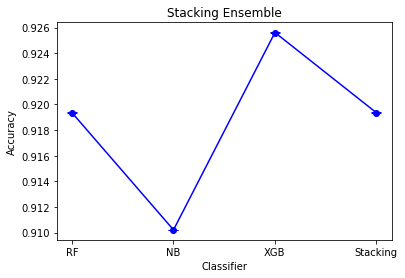

In [55]:
#sclf=apply_ensemble_classifier(df)

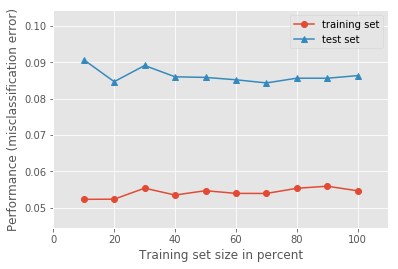

In [53]:
# #plot learning curves
# df15=df[df['type']=='Train']
# y = df15['Listing_Type']
# X = df15.drop(['Listing_Type','type','ID'], axis =1)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
# plt.figure()
# plot_learning_curves(X_train, y_train, X_test, y_test, sclf, print_model=False, style='ggplot')
# plt.show()

In [66]:
# # Fit on train data / predict on test data
# sclf_fit = sclf.fit(X_train, y_train)

In [68]:
# mypreds = sclf_fit.predict(X_test)

              precision    recall  f1-score   support

           0       0.54      0.68      0.61      9175
           1       0.97      0.94      0.95     92075

   micro avg       0.92      0.92      0.92    101250
   macro avg       0.75      0.81      0.78    101250
weighted avg       0.93      0.92      0.92    101250

F1 score for all clasess is  [0.60520231 0.95490261]
TP 86772
TN 6282
FP 2893
FN 5303


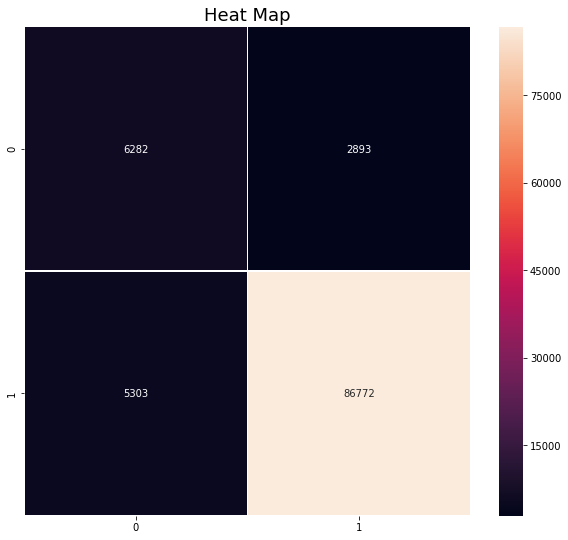

In [69]:
# cnf_matrix=confusion_matrix(y_test,mypreds)
# fig, ax = plt.subplots(figsize=(10,9))
# sns.heatmap(cnf_matrix,annot=True,linewidths=0.5,ax=ax,fmt='d')
# plt.title('Heat Map',fontsize=18)
# #cmap="coolwarm_r"
# print(classification_report(y_test,mypreds))
# f1 = f1_score(y_test,mypreds,average=None)
# #print("Iter & Depth is",(i,d))
# print("F1 score for all clasess is ",f1)
# print("TP",cnf_matrix[1,1,]) 
# print("TN",cnf_matrix[0,0]) 
# print("FP",cnf_matrix[0,1]) 
# print("FN",cnf_matrix[1,0])

In [84]:
def modelsstacking(df):
    sclf=apply_ensemble_classifier(df)
    #plot learning curves
    df15=df[df['type']=='Train']
    y = df15['Listing_Type']
    X = df15.drop(['Listing_Type','type','ID'], axis =1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    plt.figure()
    plot_learning_curves(X_train, y_train, X_test, y_test, sclf, print_model=False, style='ggplot')
    plt.show()

    # Fit on train data / predict on test data
    sclf_fit = sclf.fit(X_train, y_train)

    mypreds = sclf_fit.predict(X_test)

    cnf_matrix=confusion_matrix(y_test,mypreds)
    fig, ax = plt.subplots(figsize=(10,9))
    sns.heatmap(cnf_matrix,annot=True,linewidths=0.5,ax=ax,fmt='d')
    plt.title('Heat Map',fontsize=18)
    #cmap="coolwarm_r"
    print(classification_report(y_test,mypreds))
    f1 = f1_score(y_test,mypreds,average=None)
    #print("Iter & Depth is",(i,d))
    print("F1 score for all clasess is ",f1)
    print("TP",cnf_matrix[1,1,]) 
    print("TN",cnf_matrix[0,0]) 
    print("FP",cnf_matrix[0,1]) 
    print("FN",cnf_matrix[1,0])

    #plot learning curves
    df16=df[df['type']=='Test']
    print(df16.shape)
    #y = df15['Listing_Type']
    X = df16.drop(['Listing_Type','type','ID'], axis =1)
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    #plt.figure()
    #plot_learning_curves(X_train, y_train, X_test, y_test, sclf, print_model=False, style='ggplot')
    #plt.show()
    ##predict

    predictions=sclf_fit.predict(X)

    finaldf=pd.DataFrame(np.hstack([df16,pd.DataFrame(predictions)]))
    cols=list(df16.columns)
    cols.append('predictions')
    finaldf.columns=cols

    finaldf=finaldf.drop('Listing_Type',axis=1)

    finaldf['Listing_Type']=finaldf.apply(lambda x : 'Good' if x['predictions']==1 else 'Bad',axis=1)

    finaldf[['ID','predictions','Listing_Type']].to_csv(r'C:\Users\kishore.kukreja\Downloads\listings\listings_output.csv')
    return finaldf

In [85]:
def predictListingType(train_csv,test_csv):
    ##
    print('Preparing Data')
    df=prepareData(train_csv,test_csv)
    print('Applying Models and genearting predictions')
    results=modelsstacking(df)
    return results

In [ ]:
if __name__ == "__main__":
    print('calling predictListingType function')
    train_csv=r'C:\Users\kishore.kukreja\Downloads\listings\listings.csv'
    test_csv=r'C:\Users\kishore.kukreja\Downloads\listings_test_send\listings_test_send.csv'
    results=predictListingType(train_csv,test_csv)